延用week3的股價資料，完成本次作業要求：
1. 使用Python建立ARIMA模型，預測股票價格，並進行可視化。

In [1]:
import yfinance as yf
import pandas as pd
import datetime as dt

# 設定股票代號與時間範圍
stock_id = '2330.TW'  # .TW 是用來查詢台股的標識
end = dt.date.today()
start = end - dt.timedelta(days=180)

# 使用 yfinance 抓取股票數據
df_stat = yf.download(stock_id, start=start, end=end)

# 提取收盤價
close_prices = df_stat['Close']

# 訓練集和測試集的拆分
train_size = int(len(close_prices) * 0.7)
train_data, test_data = close_prices[:train_size], close_prices[train_size:]

# 打印訓練集和測試集的大小
print(f"訓練集大小: {len(train_data)}")
print(f"測試集大小: {len(test_data)}")

[*********************100%***********************]  1 of 1 completed

訓練集大小: 84
測試集大小: 36


In [2]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

股價走勢

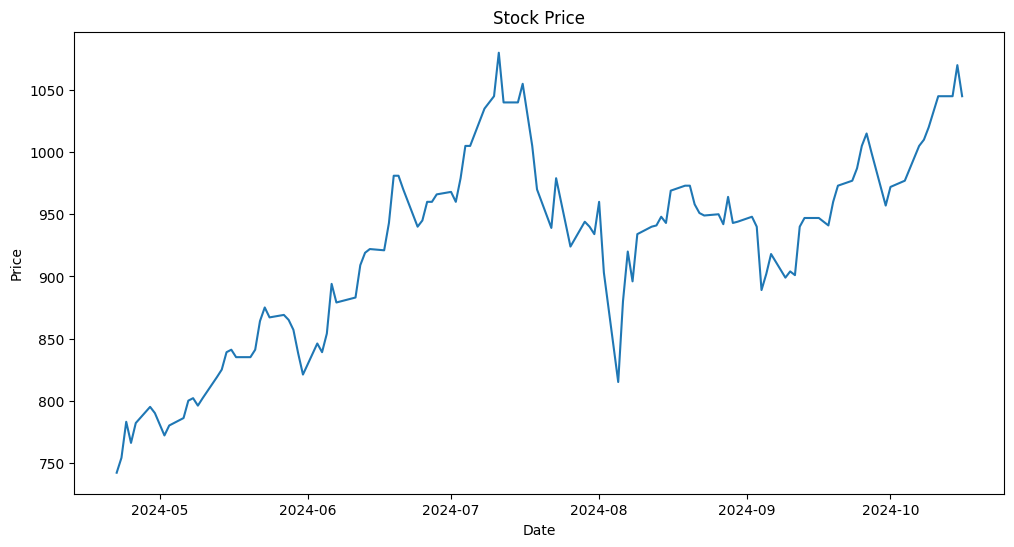

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(close_prices)
plt.title('Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

ADF 檢定-檢查平穩性 如果 p-value < 0.05，則數據是平穩的；否則需要進行差分處理

In [4]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(close_prices)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.046641
p-value: 0.266504


確定模型階數

In [5]:
def optimize_arima_parameters(train, p_values, d_values, q_values):
  best_score, best_cfg = float("inf"), None
  best_model = None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        try:
          model = ARIMA(train, order=(p, d, q))
          model_fit = model.fit()
          yhat = model_fit.forecast(steps=len(test_data))
          error = mean_squared_error(test_data, yhat)
          if error < best_score:
            best_score, best_cfg = error, (p, d, q)
            best_model = model_fit
        except:
          continue
    return best_cfg, best_model

p_values = range(0,8)
d_values = range(0,4)
q_values = range(0,8)

best_cfg, best_model = optimize_arima_parameters(train_data, p_values, d_values, q_values)

print(f'最佳參數{best_cfg}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

最佳參數(0, 2, 3)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


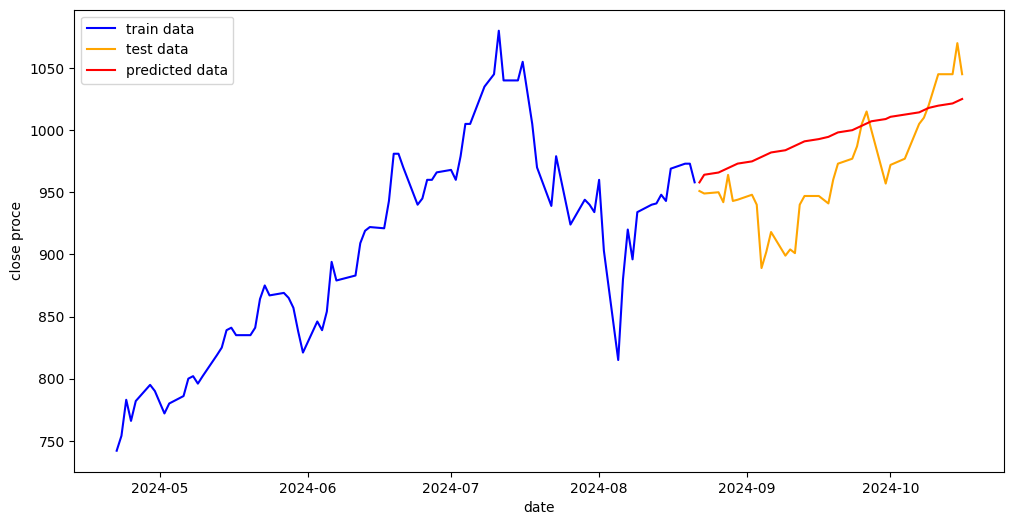

In [6]:
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

# 預測
yhat = best_model.forecast(steps=len(test_data))

# 繪製股價走勢與預測圖
plt.figure(figsize=(12, 6))

# 繪製訓練數據線
plt.plot(train_data.index, train_data, label='train data', color='blue')

# 繪製測試數據線
plt.plot(test_data.index, test_data, label='test data', color='orange')

# 繪製預測數據線
plt.plot(test_data.index, yhat, label='predicted data', color='red')

# 添加標題與標籤
plt.xlabel('date')
plt.ylabel('close proce')

# 顯示圖例
plt.legend()

# 顯示圖表
plt.show()

In [7]:
# 計算誤差 RMSE
rmse_optimized = sqrt(mean_squared_error(test_data, yhat))

# 印出誤差 RMSE
print(f'RMSE: {rmse_optimized}')

# 檢查 AIC 和 BIC
print(f"AIC: {best_model.aic}")
print(f"BIC: {best_model.bic}")

RMSE: 42.815142085706135
AIC: 758.1295070811409
BIC: 767.7563840701979


2. 使用Python設計一個量化交易策略，並使用歷史資料進行回測。

# 策略


	•	如果模型預測價格將上升，則「買入」。
	•	如果模型預測價格將下降，則「賣出」。
	•	如果預測沒有變化或變化較小，則「保持不動」。

In [9]:
#pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 5.3 MB/s eta 0:00:00


In [10]:
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import backtrader as bt

In [11]:
import backtrader as bt

# 將 yhat 轉換為列表
yhat = yhat.tolist()

# ARIMA 預測策略
class ARIMAStrategy(bt.Strategy):
    def __init__(self, forecast):
        self.forecast = forecast  # 將 ARIMA 模型的預測結果作為策略的基礎
        self.index = 0  # 用來遍歷預測結果

    def next(self):
        if self.index >= len(self.forecast):
            return  # 預測已經用完

        predicted_price = self.forecast[self.index]  # 當前的預測價格
        actual_price = self.data.close[0]  # 當前的實際價格

        # 打印當前收盤價和預測價格，便於調試
        print(f"Actual Close Price: {actual_price}, Predicted Price: {predicted_price}")

        # 如果預測價格上升，則買入
        if predicted_price > actual_price and not self.position:
            self.buy()

        # 如果預測價格下降，則賣出
        elif predicted_price < actual_price and self.position:
            self.sell()

        self.index += 1  # 移動到下一個預測價格

In [12]:
# 進行回測時
cerebro = bt.Cerebro()

# 創建 backtrader 的 PandasData 並指定列
datafeed = bt.feeds.PandasData(
    dataname=df_stat,
    open='Open',  # 開盤價列
    high='High',  # 最高價列
    low='Low',    # 最低價列
    close='Close',  # 收盤價列
    volume='Volume'  # 成交量列
)

# 將數據添加到回測引擎
cerebro.adddata(datafeed)

# 添加 ARIMA 預測策略
cerebro.addstrategy(ARIMAStrategy, forecast=yhat)

# 設定初始現金
cerebro.broker.set_cash(100000)

# 設置交易費率
cerebro.broker.setcommission(commission=0.001)

# 執行回測
print(f'初始資金: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'最終資金: {cerebro.broker.getvalue():.2f}')

# 繪製回測結果
cerebro.plot()

初始資金: 100000.00
Actual Close Price: 742.0, Predicted Price: 957.921480541712
Actual Close Price: 754.0, Predicted Price: 964.0916400450557
Actual Close Price: 783.0, Predicted Price: 965.8849695975885
Actual Close Price: 766.0, Predicted Price: 967.6782991501211
Actual Close Price: 782.0, Predicted Price: 969.4716287026538
Actual Close Price: 795.0, Predicted Price: 971.2649582551865
Actual Close Price: 790.0, Predicted Price: 973.0582878077191
Actual Close Price: 772.0, Predicted Price: 974.8516173602518
Actual Close Price: 780.0, Predicted Price: 976.6449469127845
Actual Close Price: 786.0, Predicted Price: 978.4382764653171
Actual Close Price: 800.0, Predicted Price: 980.2316060178498
Actual Close Price: 802.0, Predicted Price: 982.0249355703825
Actual Close Price: 796.0, Predicted Price: 983.8182651229151
Actual Close Price: 802.0, Predicted Price: 985.6115946754478
Actual Close Price: 819.0, Predicted Price: 987.4049242279805
Actual Close Price: 825.0, Predicted Price: 989.1982537

<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 4 Axes>]]